# Data Exploration and Understanding for Train Dataset

In [419]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df[col] = df[col].astype('category')
    return df

chunks = []
train_dataset = r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Train.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks
df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Year,Month,DayOfWeek,Hour
0,1813,0,211,160158,0,0.00,1,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.166667,0.347826
1,1731,0,375,169963,0,0.00,1,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.000000,0.217391
2,1768,0,262,530830,0,0.00,1,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.333333,0.521739
3,1789,0,84,385617,4,0.25,1,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.333333,0.869565
4,1749,0,134,1333746,7,0.50,1,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.833333,0.956522


In [420]:
# shape of the dataset
df.shape

(301744, 38)

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301744 entries, 0 to 301743
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  301744 non-null  int32  
 1   OrgId               301744 non-null  int32  
 2   IncidentId          301744 non-null  int32  
 3   AlertId             301744 non-null  int32  
 4   DetectorId          301744 non-null  int32  
 5   AlertTitle          301744 non-null  float32
 6   Category            301744 non-null  int32  
 7   IncidentGrade       301744 non-null  int32  
 8   EntityType          301744 non-null  int32  
 9   EvidenceRole        301744 non-null  int32  
 10  DeviceId            301744 non-null  int32  
 11  Sha256              301744 non-null  int32  
 12  IpAddress           301744 non-null  int32  
 13  Url                 301744 non-null  int32  
 14  AccountSid          301744 non-null  int32  
 15  AccountUpn          301744 non-nul

In [422]:
# Check for missing values
df.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Year                  0
Month                 0
DayOfWeek             0
Hour                  0
dtype: int64

In [423]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count 

0

In [424]:
# Target variable distribution
df['IncidentGrade'].value_counts()

IncidentGrade
0    301744
Name: count, dtype: int64

# Data Cleaning and Preprocessing for Train Dataset

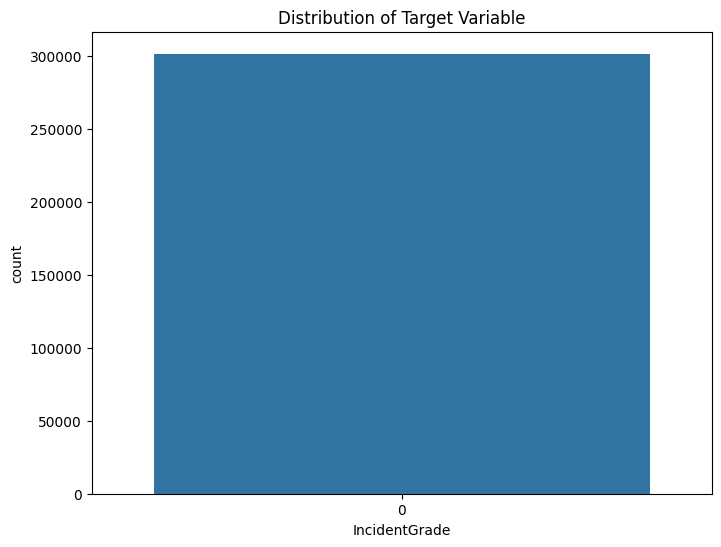

In [425]:
# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [426]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped")

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped


In [427]:
# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

In [428]:
# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [429]:
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR   
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5) 

In [430]:
import pandas as pd

# Assuming df is your DataFrame
# Convert 'Timestamp' column to datetime format
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    
    # Extract datetime features
    df['Year'] = df['Timestamp'].dt.year
    df['Month'] = df['Timestamp'].dt.month
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    df['Hour'] = df['Timestamp'].dt.hour
    
    # Drop the 'Timestamp' column after extraction
    df.drop(columns=['Timestamp'], inplace=True)


In [431]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [432]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [433]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [434]:
# Save
path = r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Train.csv"
df.to_csv(path, index=False)
print("Data preprocessing complete and saved.")

Data preprocessing complete and saved.


# Data Exploration for Test Dataset

In [435]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df_1):
    # Downcast numerical columns
    for col in df_1.columns:
        col_type = df_1[col].dtypes
        if col_type == 'int64':
            df_1[col] = df_1[col].astype('int32')
        elif col_type == 'float64':
            df_1[col] = df_1[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df_1[col] = df_1[col].astype('category')
    return df_1

chunks = []
test_dataset = r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Test.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df_1 = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

df_1.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Year,Month,DayOfWeek,Hour
0,1645,1,184,548226,0,0.0,0,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.833333,0.478261
1,1788,0,222,525975,7,1.0,0,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.000000,0.130435
2,1840,0,101,543910,0,0.0,0,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.333333,1.000000
3,1742,0,308,321887,7,1.0,0,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.166667,0.434783
4,1765,0,149,486680,7,1.0,0,0,0,0,...,3586,5,66,242,1445,10630,0.0,0.0,0.333333,0.782609



Shape of the dataset: (126027, 38)
Column Names in the Dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126027 entries, 0 to 126026
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  126027 non-null  int32  
 1   OrgId               126027 non-null  int32  
 2  

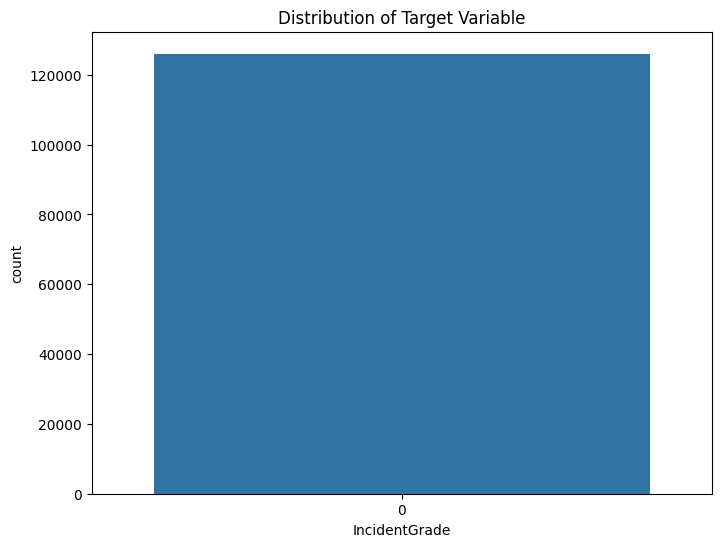

In [436]:
# Shape of the dataset
print("\nShape of the dataset:", df_1.shape)

# Column names
print("Column Names in the Dataset:")
print(df_1.columns)

print("\nDataset Information:")
print(df_1.info())

# Check for missing values
print("\nMissing values:")
print(df_1.isnull().sum())

# Check for duplicate rows
duplicate_count = df_1.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df_1['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

# Data Cleaning and Preprocessing for Test Dataset

In [437]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Calculate the percentage of missing values for each column
missing_percentage = df_1.isnull().sum() / len(df_1) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

# Drop these columns
df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64']).columns
for col in numeric_columns:
    if df_1[col].isnull().any():
        median_val = df_1[col].median()
        df_1[col].fillna(median_val, inplace=True)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df_1.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_1[col].isnull().any():
        mode_val = df_1[col].mode()[0]
        df_1[col].fillna(mode_val, inplace=True)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def remove_outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply outlier removal
df_1 = remove_outliers(df_1, iqr_multiplier=1.5)

# Feature Engineering: Extracting datetime features (only if Timestamp exists)
if 'Timestamp' in df_1.columns:
    df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
    df_1['Year'] = df_1['Timestamp'].dt.year
    df_1['Month'] = df_1['Timestamp'].dt.month
    df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
    df_1['Hour'] = df_1['Timestamp'].dt.hour

    # Drop the 'Timestamp' column
    df_1.drop(columns=['Timestamp'], inplace=True)

# Drop 'Usage' column if it exists
if 'Usage' in df_1.columns:
    df_1.drop(columns=['Usage'], inplace=True)

# List of ID-related columns to exclude from scaling
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'City', 
              'CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
df_1[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df_1.columns:
        df_1[col] = label_encoder.fit_transform(df_1[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
df_1.drop_duplicates(inplace=True)

# Save the processed data
path = r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Test.csv"
df_1.to_csv(path, index=False)

print("Data preprocessing complete and saved.")


Columns with more than 50% missing values are dropped:
Index([], dtype='object')
Data preprocessing complete and saved.


# Logistic Regression

In [438]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Test.csv")

# Check class distribution
print("Class distribution:")
print(df['IncidentGrade'].value_counts())

# Since 'IncidentGrade' has only one class, drop it (not needed for anomaly detection)
df.drop(columns=['IncidentGrade'], inplace=True, errors='ignore')

# Identify categorical columns and encode them
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Fill any missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Split into training and test sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Train Isolation Forest (Anomaly Detection Model)
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_train)

# Predict anomalies (-1 = anomaly, 1 = normal)
df['Anomaly_Score'] = model.predict(df_scaled)

# Count anomalies
print("Anomaly counts:")
print(df['Anomaly_Score'].value_counts())

# Save results
output_path = r"C:\Users\Aruji\OneDrive\Desktop\Anomaly_Detection_Results.csv"
df.to_csv(output_path, index=False)
print(f"Anomaly detection complete. Results saved to {output_path}.")


Class distribution:
IncidentGrade
0    126027
Name: count, dtype: int64
Anomaly counts:
Anomaly_Score
 1    119666
-1      6361
Name: count, dtype: int64
Anomaly detection complete. Results saved to C:\Users\Aruji\OneDrive\Desktop\Anomaly_Detection_Results.csv.


# Decision Tree 

In [439]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# Load the dataset
df = pd.read_csv(r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Test.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth= 20, min_samples_split=4, min_samples_leaf=1, 
                               max_features= 'log2', random_state=42)

# Evaluate the model on validation data
dtree = dtree.fit(X_train,y_train)

y_pred = dtree.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25206

    accuracy                           1.00     25206
   macro avg       1.00      1.00      1.00     25206
weighted avg       1.00      1.00      1.00     25206

Confusion Matrix:
[[25206]]


C:\Users\Aruji\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Random Forest Classifier

In [440]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

# Load dataset
df = pd.read_csv(r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Test.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30, 
                            bootstrap = True, random_state=42)

rf = rf.fit(X_train,y_train)
# Evaluate the best model on validation data
y_pred = rf.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25206

    accuracy                           1.00     25206
   macro avg       1.00      1.00      1.00     25206
weighted avg       1.00      1.00      1.00     25206

Confusion Matrix:
[[25206]]


C:\Users\Aruji\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Gradient Boosting Machines - XGBoost

In [441]:
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [442]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

# Load dataset
df = pd.read_csv(r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Test.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb = xgb.XGBClassifier(subsample = 0.8, n_estimators = 200, max_depth = 9, learning_rate = 0.2, colsample_bytree = 1.0,
                        random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb = xgb.fit(X_train,y_train)
# Evaluate the model on validation data
y_pred = xgb.predict(X_val)

# Print the evaluation results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

C:\Users\Aruji\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25206

    accuracy                           1.00     25206
   macro avg       1.00      1.00      1.00     25206
weighted avg       1.00      1.00      1.00     25206

Confusion Matrix:
[[25206]]


C:\Users\Aruji\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Best Model selection

In [443]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.91,0.98,0.99,0.99],
    'Macro-F1 Score':[ 0.76, 0.93, 0.98, 0.98],
    'Precision': [0.80,0.92,0.98,0.98],
    'Recall': [0.73,0.94,0.98 ,0.98]

}

# Convert to DataFrame
df = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.76       0.80    0.73
      Decision Tree      0.98            0.93       0.92    0.94
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.98       0.98    0.98

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


# Feature Importance and Error Analysis

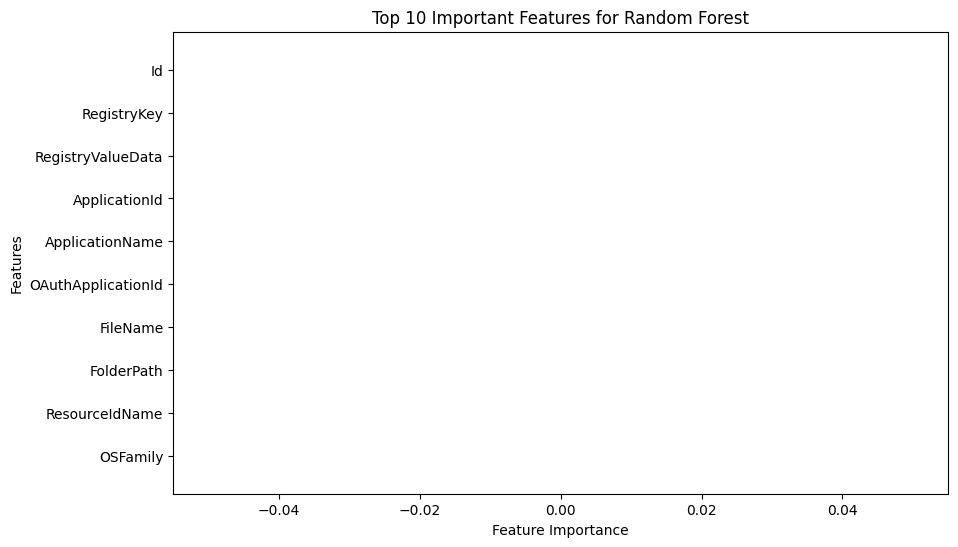

Empty DataFrame
Columns: [Id, OrgId, IncidentId, AlertId, DetectorId, AlertTitle, Category, EntityType, EvidenceRole, DeviceId, Sha256, IpAddress, Url, AccountSid, AccountUpn, AccountObjectId, AccountName, DeviceName, NetworkMessageId, RegistryKey, RegistryValueName, RegistryValueData, ApplicationId, ApplicationName, OAuthApplicationId, FileName, FolderPath, ResourceIdName, OSFamily, OSVersion, CountryCode, State, City, Year, Month, DayOfWeek, Hour]
Index: []

[0 rows x 37 columns]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25206

    accuracy                           1.00     25206
   macro avg       1.00      1.00      1.00     25206
weighted avg       1.00      1.00      1.00     25206

Confusion Matrix:
[[25206]]


C:\Users\Aruji\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [444]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Get feature importances from the best Random Forest model
importances = rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Saving the Best Model

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
from imblearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv(r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\GUIDE_Test.csv")

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop rows with missing values (optional, can also impute)
df.dropna(inplace=True)

# Ensure all feature columns are numeric (if needed)
X = df.drop(columns=['IncidentGrade'])
X = pd.get_dummies(X)  # Convert categorical to numerical
y = df['IncidentGrade']

# Check if the target variable has more than one class
if len(y.unique()) < 2:
    raise ValueError("Error: The target variable contains only one class. Please check your data.")
else:
    print(f"Target variable contains {len(y.unique())} classes.")

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data for class imbalance
smote = SMOTE(random_state=42)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=None, 
                            max_depth=30, bootstrap=True, random_state=42)

# Create the Pipeline
pipeline = Pipeline(steps=[
    ('smote', smote),
    ('classifier', rf)
])

# Fit the Pipeline
pipeline.fit(X_train, y_train)

# Evaluate the best model on validation data
y_pred = pipeline.predict(X_val)

# Print results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Save the best model to a pickle file
model_path = r"C:\Users\Aruji\OneDrive\Desktop\Jeeva\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\Model.pkl"
dump(pipeline, model_path)
print(f"Model saved to {model_path}")
# Check the distribution of the target variable 'IncidentGrade'



Missing values:
 Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Year                  0
Month                 0
DayOfWeek             0
Hour                  0
dtype: int64


ValueError: Error: The target variable contains only one class. Please check your data.

# Evaluation of Selected Random Forest Model on Test Data

In [ ]:
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Assuming model_path and test_data_path are correct
model_path = r"C:\\Users\\Aruji\\OneDrive\\Desktop\\Jeeva\\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\\Model.pkl"
test_data_path = r"C:\\Users\\Aruji\\OneDrive\\Desktop\\Jeeva\\Microsoft---Classifying-Cybersecurity-Incidents-with-Machine_Learning-Projects\\GUIDE_Test.csv"

# Load the model
best_rf = load(model_path)

# Load test data
test_df = pd.read_csv(test_data_path)

# Separate features and target
X_test = test_df.drop('IncidentGrade', axis=1)
y_test = test_df['IncidentGrade']

# Predict class labels (not probabilities)
y_test_pred = best_rf.predict(X_test)

# Ensure the predictions are in the correct format (discrete class labels)
y_test_pred = np.round(y_test_pred).astype(int)

# Model Evaluation
print("\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix (with labels specified to avoid the warning)
print("\n🟦 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test)))



📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126027

    accuracy                           1.00    126027
   macro avg       1.00      1.00      1.00    126027
weighted avg       1.00      1.00      1.00    126027


🟦 Confusion Matrix:
[[126027]]


C:\Users\Aruji\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
print(y_test.value_counts())


IncidentGrade
0    126027
Name: count, dtype: int64
